In [13]:
# needed imports for this notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sweetviz as sv
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from autogluon.tabular import TabularPredictor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer




In [14]:
# load csv file ad pandas dataframe
df_original = pd.read_csv('D:\FU WINFO\I\Applied Analytics\kip_sdm_syn.csv')

In [15]:
# ignore columns "fall-while_stay" and "fall-while_transfer" as they are already included in outcome and not relevant for general risk assessment
# this code also overwrites "fallen", if one of those columns is 1
columns_to_drop = ["fall-while_stay", "fall-while_transfer"]

# Update the "fallen" column based on the conditions
df_original.loc[
    ((df_original["fall-while_stay"] == 1) | (df_original["fall-while_transfer"] == 1)) & (df_original["fallen"] == 0),
    "fallen"
] = 1

# Drop the irrelevant columns
df = df_original.drop(columns=columns_to_drop)

C:\Users\Veit\AppData\Local\Temp\ipykernel_16608\2141733088.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_original.loc[


Current singular procedure most likely won't have effect on future falling risk; diagnosis might have an impact, though

In [16]:
df = df.drop(columns='procedure')

In [17]:
# decubitus-admission, medical_items-A_V_system: drop since only distinct value is "False"
columns_to_drop = ["decubitus-admission", "medical_items-A_V_system"]
df = df.drop(columns=columns_to_drop)

In [18]:
# remove real float values from "fall-how_many_last_12_month" column since we assume they are a data error
df["fall-how_many_last_12_month"] = df["fall-how_many_last_12_month"].dropna().apply(
    lambda x: int(x) if isinstance(x, float) and x == int(x) else pd.NA
)
df["fall-how_many_last_12_month"] = df["fall-how_many_last_12_month"].astype("Int64")


In [19]:
# if walk-impairment empty and (walking_aid == 1 or walk_jones not empty), then set walk-impairment to 1
# Iterate through rows and update 'walk-impairment' based on the condition
for index, row in df.iterrows():
    if pd.isna(row['walk-impairment']):  # Check if 'walk-impairment' is NaN
        if row['walking_aid'] == 1:  # Check if 'walking_aid' is 1
            df.at[index, 'walk-impairment'] = 1  # Set 'walk-impairment' to 1
        elif pd.notna(row['walk-jones']):  # Check if 'walk-jones' is not NaN
            df.at[index, 'walk-impairment'] = 1  # Set 'walk-impairment' to 1


Transform Text columns using one hot encoding

In [20]:
# convert bed_mobility-jones, transfer and walk-jones to one-hot encoded columns
# Assuming `columns_to_transform` is the list of columns you want to transform
columns_to_transform = ['bed_mobility-jones', 'transfer', 'walk-jones', 'diagnosis']  # Replace with your column names

for col in columns_to_transform:
    # Create one-hot encoded columns for each distinct value in the column
    dummies = pd.get_dummies(df[col], prefix=col)
    # Add the new columns to the DataFrame
    df = pd.concat([df, dummies], axis=1)
    # Drop the original column
    df = df.drop(columns=[col])

Reduce diagnoses sparingly (correlation >= 0.01 to fallen are kept) to have fewer columns (300 instead of 3000)

In [21]:
# Step 1: Identify one-hot encoded diagnosis columns
diagnosis_columns = [col for col in df.columns if col.startswith('diagnosis_')]

# Step 2: Calculate correlations with the outcome variable "fallen"
correlations = df[diagnosis_columns].corrwith(df['fallen']).abs()

# Step 3: Sort correlations in descending order
sorted_correlations = correlations.sort_values(ascending=False)

# Step 4: Display all diagnosis columns and their correlations
print("Correlations of diagnosis columns with 'fallen':")
print(sorted_correlations)

# Step 5: Filter columns with correlation >= 0.05
high_correlation_columns = sorted_correlations[sorted_correlations >= 0.01].index.tolist()

# Step 6: Drop low-correlation diagnosis columns
low_correlation_columns = [col for col in diagnosis_columns if col not in high_correlation_columns]
df = df.drop(columns=low_correlation_columns)

# Step 7: Verify the remaining columns
print(f"\nNumber of diagnosis columns retained: {len(high_correlation_columns)}")
print(f"Number of diagnosis columns removed: {len(low_correlation_columns)}")

Correlations of diagnosis columns with 'fallen':
diagnosis_N26     0.031887
diagnosis_T96     0.028882
diagnosis_0       0.027945
diagnosis_N410    0.026034
diagnosis_S468    0.025265
                    ...   
diagnosis_G463    0.000155
diagnosis_L851    0.000155
diagnosis_G820    0.000155
diagnosis_I483    0.000155
diagnosis_A419    0.000005
Length: 3345, dtype: float64

Number of diagnosis columns retained: 208
Number of diagnosis columns removed: 3137


In [22]:
print(df.columns)

Index(['fallen', 'id', 'age', 'c_zriserh1', 'decubitus-at_the_moment',
       'bed_mobility-impairment', 'bed_mobility-skin_condition',
       'transfer-impairment', 'medical_items',
       'medical_items-arm_or_leg_splint',
       ...
       'diagnosis_Z129', 'diagnosis_Z132', 'diagnosis_Z135', 'diagnosis_Z355',
       'diagnosis_Z640', 'diagnosis_Z855', 'diagnosis_Z862', 'diagnosis_Z884',
       'diagnosis_Z941', 'diagnosis_Z944'],
      dtype='object', length=259)


In [23]:
# Convert all boolean columns to numeric (False -> 0, True -> 1, NA -> NaN)
bool_columns = [
    col for col in df.columns 
    if df[col].dropna().isin([True, False]).all()
]
df[bool_columns] = df[bool_columns].apply(lambda col: col.map({True: 1, False: 0}))

In [24]:
# 2. decubitus-risk & fall-risk: adjust columns having "+" and "++" values to numerical values
columns_to_modify = ["decubitus-risk", "fall-risk"] 

value_mapping = {
    '0': 0,
    '+': 1,
    '++': 2
}

df[columns_to_modify] = df[columns_to_modify].replace(value_mapping)

C:\Users\Veit\AppData\Local\Temp\ipykernel_16608\1550453215.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_modify] = df[columns_to_modify].replace(value_mapping)


In [25]:
# sex: transform to numeric binary value 

df['is_male'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)
# Drop the 'sex' column
df = df.drop(columns=['sex'])

C:\Users\Veit\AppData\Local\Temp\ipykernel_16608\2735883329.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_male'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)


In [26]:
# Select all float columns
float_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Convert float columns to nullable integers (Int64)
df[float_columns] = df[float_columns].apply(lambda col: col.astype('Int64'))

In [27]:
# Check for missing data in the remaining columns
missing_data = df.isnull().sum()

# Filter to show only columns with missing values
missing_data = missing_data[missing_data > 0]

# Display the columns with missing data and the number of missing values
print("Columns with missing data and their counts:")
print(missing_data)

Columns with missing data and their counts:
decubitus-at_the_moment                             30401
bed_mobility-impairment                             28872
bed_mobility-skin_condition                         38447
transfer-impairment                                 28588
medical_items                                       29203
medical_items-skin_condition_at_item_application    38637
fall-last_12_month                                  29853
fall-how_many_last_12_month                         38615
walk-impairment                                     25586
excretions-impairment                               29917
cognition-impairment                                29957
psychotropic_or_sedatives_drugs                     30203
decubitus-risk                                      28511
fall-risk                                           27672
diseases                                            29956
dtype: int64


In [28]:


# Step 1: Identify columns with missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]  # Filter columns with missing values

# Step 3: Filter the DataFrame to include numeric and encoded text columns
numeric_df = df.select_dtypes(include=["number"])

# Step 4: Find relevant columns for each column with missing data (all those columns having a one-dimensional correlation of > 0.1 with the respective column)
relevant_columns_dict = {}
for col in missing_data.index:  # Use columns with missing data from 'missing_data'
    # Calculate correlations with other numeric columns
    correlations = numeric_df.corr()[col].dropna().abs().sort_values(ascending=False)
    # Select columns with significant correlation (e.g., > 0.1)
    relevant_columns = correlations[correlations > 0.1].index.tolist()
    relevant_columns_dict[col] = relevant_columns

# Step 5: Print relevant columns for each column with missing data
for col, relevant_cols in relevant_columns_dict.items():
    print(f"Relevant columns for '{col}': {relevant_cols}")

Relevant columns for 'decubitus-at_the_moment': ['decubitus-at_the_moment', 'bed_mobility-skin_condition', 'medical_items-skin_condition_at_item_application', 'cognition-impairment', 'walk-jones_4B', 'bed_mobility-impairment', 'cognition-disoriented_location', 'fallen', 'excretions-impairment', 'transfer-impairment', 'cognition-disoriented_time', 'transfer_4A', 'cognition-confused', 'bed_mobility-jones_3', 'excretions-incontinence', 'walk-jones_4A', 'cognition-disoriented_own_person', 'decubitus-risk', 'bed_mobility-jones_4A', 'transfer_3', 'medical_items', 'fall-risk', 'bed_mobility-jones_4B', 'walk-impairment', 'fall-last_12_month', 'walk-jones_3', 'walk-balance_and_gait_impaired', 'medical_items-O2_glasses', 'transfer_4B', 'cognition-agitated', 'psychotropic_or_sedatives_drugs', 'walking_aid', 'diseases', 'diagnosis_S468', 'diagnosis_S499', 'diagnosis_Q850', 'diagnosis_Z355']
Relevant columns for 'bed_mobility-impairment': ['bed_mobility-impairment', 'fallen', 'transfer-impairment',

In [29]:




# Identify binary and integer columns
binary_columns = [col for col in df.columns if df[col].dropna().nunique() == 2]  # Columns with only 2 unique values
integer_columns = [col for col in df.columns if df[col].dropna().dtype == 'Int64' and col not in binary_columns]
print("Binary columns:", binary_columns)
print("Integer columns:", integer_columns)


Binary columns: ['fallen', 'c_zriserh1', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-skin_condition', 'transfer-impairment', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'walk-impairment', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disoriented_time', 'cognition-disoriented_location', 'cognition-disoriented_own_person', 'cognition-agitated', 'cognition-confused', 'psychotropic_or_sedatives_drugs', 'diseases', 'bed_mobility-jones_1', 'bed_mobility-jones_2', 'bed_mobility-jones_3', 'bed_mobility-jones_4A', 'bed_mobility-jones_4B', 'transfer_1', 'transfer_2', 'transfer_3', 'transfer_

In [30]:
# imputate missing data in columns where data is missing using only relevant columns




# Impute each column with missing data using only its relevant columns
for col, relevant_cols in relevant_columns_dict.items():
    # Ensure the column itself is included in the subset
    if col not in relevant_cols:
        relevant_cols.append(col)
    
    # Remove duplicates from relevant_cols
    relevant_cols = list(set(relevant_cols))
    
    # Create a subset of the DataFrame with relevant columns
    df_subset = df[relevant_cols]
    
    # Initialize the Iterative Imputer
    iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
    
    # Apply the imputer to the subset
    imputed_array = iterative_imputer.fit_transform(df_subset)
    df_imputed = pd.DataFrame(imputed_array, columns=relevant_cols)
    
    # Post-process the imputed column to preserve its original type
    if col in binary_columns:
        # Constrain values to 0 or 1 for binary columns
        df[col] = (df_imputed[col] > 0.5).astype(int)
    elif col in integer_columns:
        # Round to the nearest integer for integer columns
        df[col] = df_imputed[col].round().astype(int)
    else:
        # For other columns, keep the imputed values as they are
        df[col] = df_imputed[col]

# Verify that no missing values remain
print("Missing values after refined iterative imputation:")
print(df.isnull().sum().sum())  # Should print 0 if all missing values are handled



c:\Users\Veit\anaconda3\envs\aa_tuesday\lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\Veit\anaconda3\envs\aa_tuesday\lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\Veit\anaconda3\envs\aa_tuesday\lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Missing values after refined iterative imputation:
0


In [ ]:
#run sweetviz on df to generate report
report = sv.analyze(df)


                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
# show sweetviz report
report.show_html('D:\FU WINFO\I\Applied Analytics\kip_sdm_syn_report_imputated4.html')

Report D:\FU WINFO\I\Applied Analytics\kip_sdm_syn_report_imputated4.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


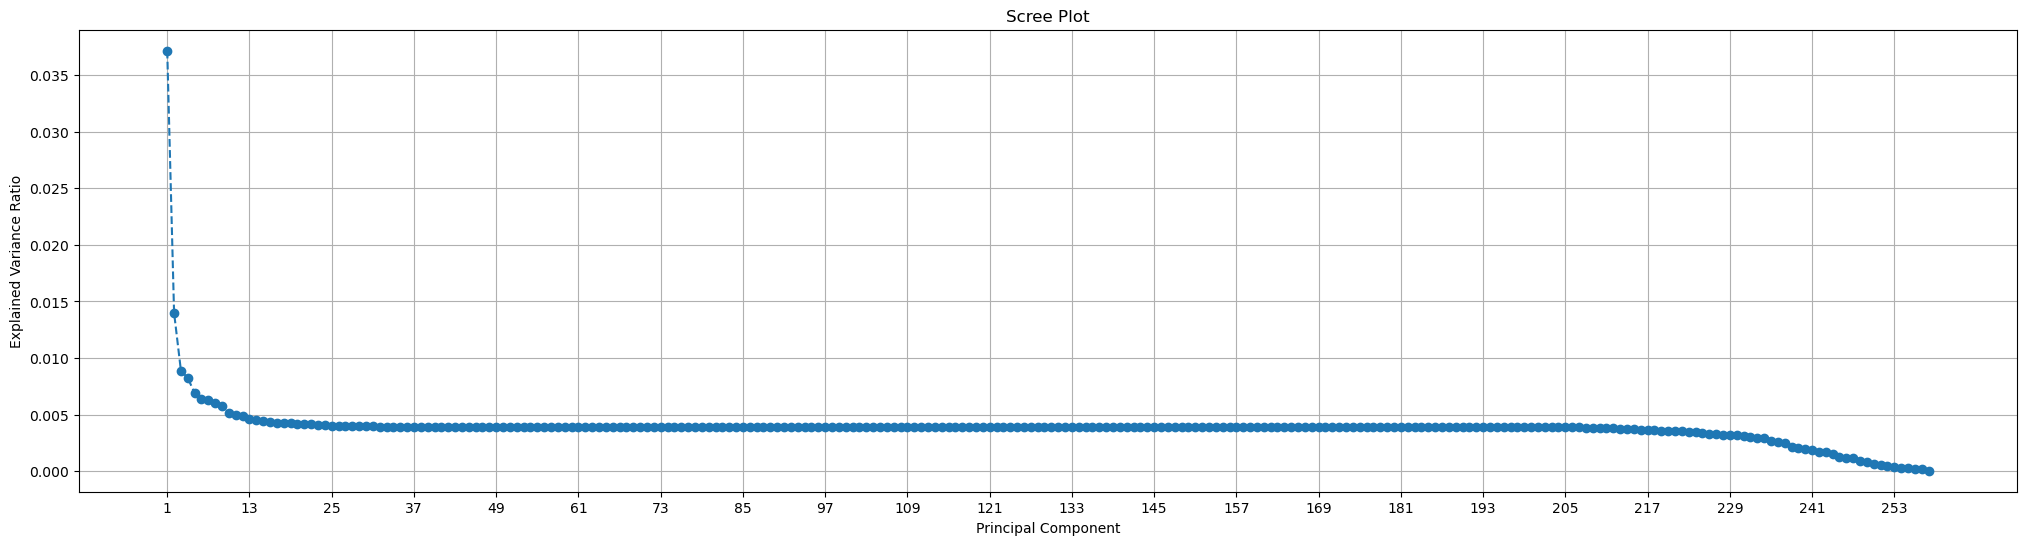

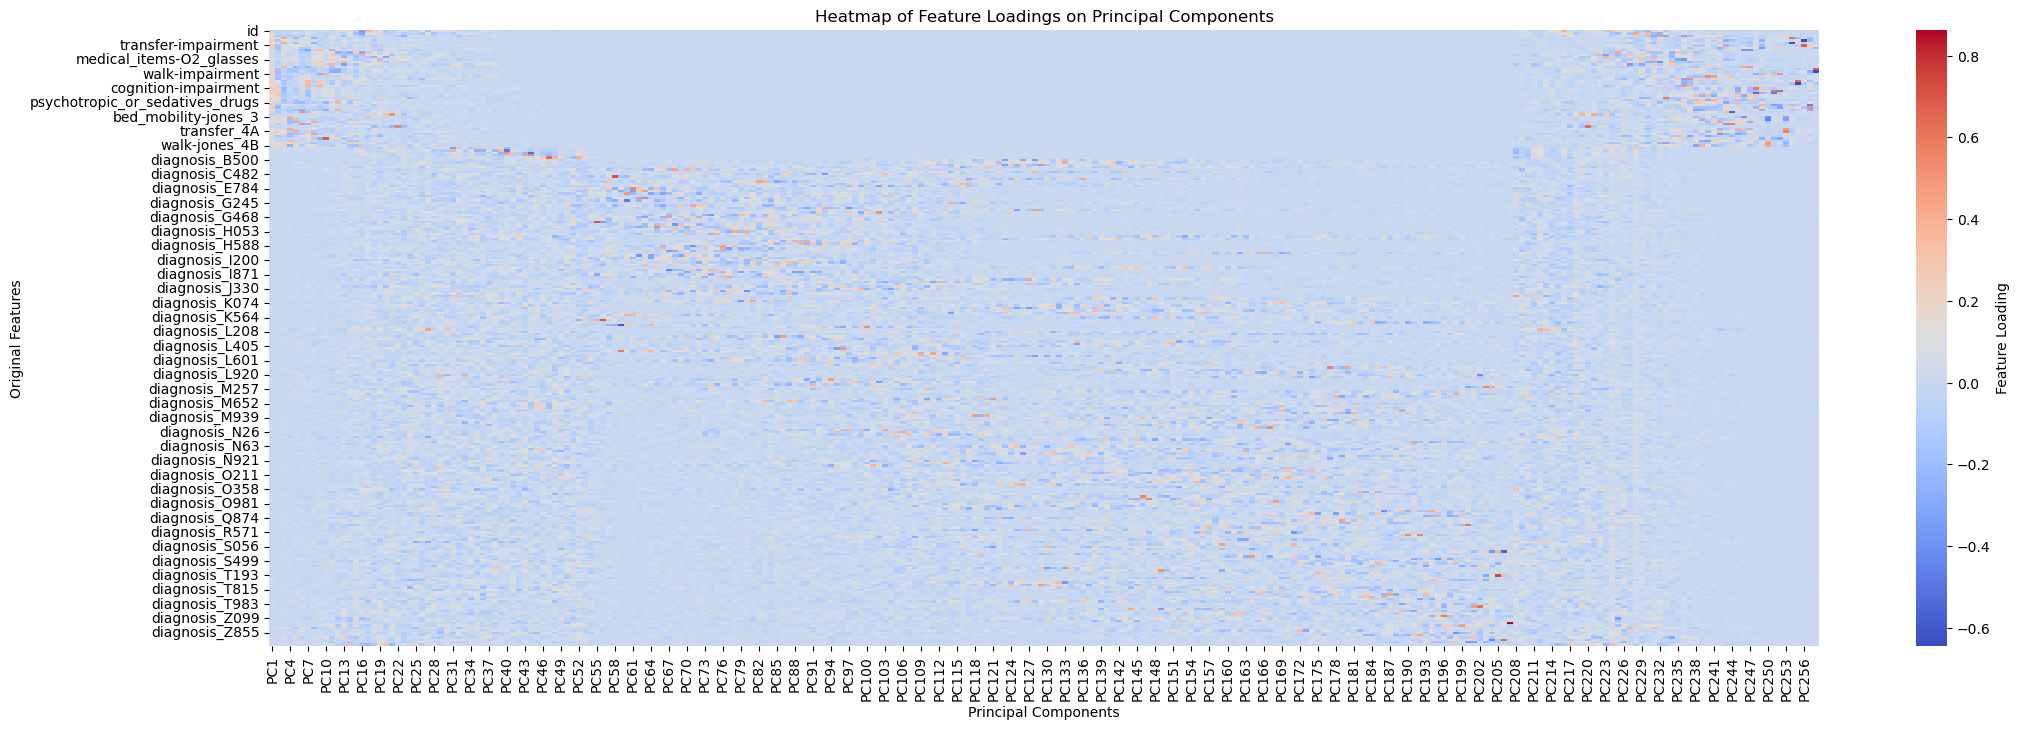

In [32]:


# Step 1: Separate the target variable and features
y = df['fallen']  # Preserve the target variable
X = df.drop(columns=['fallen'], errors='ignore')  # Drop target column for PCA

# Step 2: Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Step 3: Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_normalized)

# Step 4: Extract explained variance ratio and eigenvalues
explained_variance_ratio = pca.explained_variance_ratio_
eigenvalues = pca.components_

# Step 5: Scree Plot
plt.figure(figsize=(max(10, len(explained_variance_ratio) // 10), 6))  # Adjust width dynamically
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1, max(1, len(explained_variance_ratio) // 20)))  # Adjust tick frequency
plt.grid()
plt.show()

# Step 6: Heatmap of Feature Loadings
plt.figure(figsize=(max(12, len(loadings_df.columns) // 10), 8))  # Adjust width dynamically
sns.heatmap(loadings_df, annot=False, cmap='coolwarm', cbar_kws={'label': 'Feature Loading'})  # Set annot=False to remove text
plt.title('Heatmap of Feature Loadings on Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()

Section 3 a) Simple, interpretable Decision Tree Model

Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7515
         1.0       1.00      0.99      1.00       485

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

ROC-AUC Score: 1.00


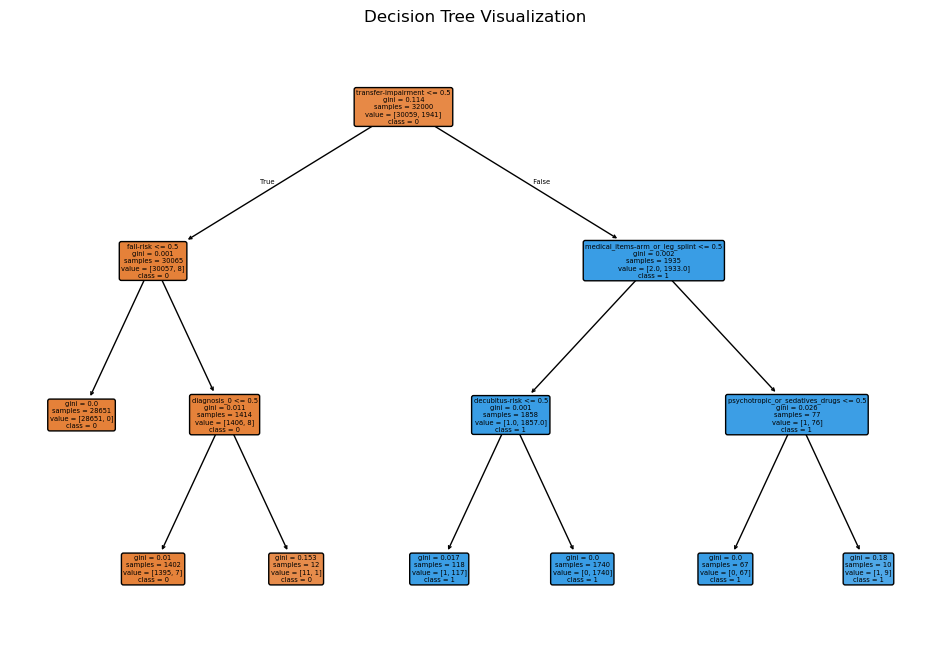

Decision Tree Rules:
|--- transfer-impairment <= 0.50
|   |--- fall-risk <= 0.50
|   |   |--- class: 0.0
|   |--- fall-risk >  0.50
|   |   |--- diagnosis_0 <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- diagnosis_0 >  0.50
|   |   |   |--- class: 0.0
|--- transfer-impairment >  0.50
|   |--- medical_items-arm_or_leg_splint <= 0.50
|   |   |--- decubitus-risk <= 0.50
|   |   |   |--- class: 1.0
|   |   |--- decubitus-risk >  0.50
|   |   |   |--- class: 1.0
|   |--- medical_items-arm_or_leg_splint >  0.50
|   |   |--- psychotropic_or_sedatives_drugs <= 0.50
|   |   |   |--- class: 1.0
|   |   |--- psychotropic_or_sedatives_drugs >  0.50
|   |   |   |--- class: 1.0



In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Step 1: Prepare the original dataset
# Assuming `df` is the original dataset and `fallen` is the target variable
X = df.drop(columns=['fallen'])
y = df['fallen']

# Split the dataset into training and testing sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 2: Train a Decision Tree with Hyperparameter Tuning
# Define the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model and hyperparameters
best_dt = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Step 3: Evaluate the Model
# Predict on the test set
y_pred = best_dt.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, best_dt.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Step 4: Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(best_dt, feature_names=X.columns, class_names=['0', '1'], filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


from sklearn.tree import export_text

# Step 5: Visualize the Decision Tree (Text-Based)
tree_rules = export_text(best_dt, feature_names=list(X.columns))
print("Decision Tree Rules:")
print(tree_rules)

Section 3 b) More complex model optimized for performance

(16 are kept using elbow method; see scree plot above)

In [37]:

# Step 1: Perform PCA and select the first 10 components
n_components = 10
pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_normalized)

# Combine the reduced features with the target variable
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(n_components)])
reduced_dataset = pd.concat([X_reduced_df, y.reset_index(drop=True)], axis=1)

# Step 2: Balance the dataset using SMOTE <---- IMPORTANT: Oversamples the dataset where fallen=1 to match the size of the majority class
X = reduced_dataset.drop(columns=['fallen'])
y = reduced_dataset['fallen']

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Combine the balanced data into a single DataFrame
balanced_dataset = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.Series(y_balanced, name='fallen')], axis=1)

# Step 3: Split the dataset into training and testing sets (stratified)
train_data, test_data = train_test_split(balanced_dataset, test_size=0.2, stratify=y_balanced, random_state=42)

# Step 4: Train the model using AutoGluon
predictor = TabularPredictor(label='fallen', eval_metric='f1').fit(
    train_data=train_data,
    time_limit=600,  # Set a time limit for training (in seconds)
    presets='best_quality'  # Use high-quality presets for better performance
)

# Step 5: Evaluate the model
leaderboard = predictor.leaderboard(test_data, silent=True)
print("Model Leaderboard:")
print(leaderboard)

# Step 6: Evaluate the best model on the test set
test_predictions = predictor.predict(test_data.drop(columns=['fallen']))
test_scores = predictor.evaluate_predictions(
    y_true=test_data['fallen'],
    y_pred=test_predictions,
    auxiliary_metrics=True
)

print("Test Set Evaluation Metrics:")
print(test_scores)

No path specified. Models will be saved in: "AutogluonModels\ag-20250325_203840"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.21
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          24
Memory Avail:       15.53 GB / 31.92 GB (48.6%)
Disk Space Avail:   98.56 GB / 931.51 GB (10.6%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout 

Model Leaderboard:
                      model  score_test  score_val eval_metric  \
0   RandomForestEntr_BAG_L2    0.998139   0.998088          f1   
1           LightGBM_BAG_L2    0.998139   0.998421          f1   
2       WeightedEnsemble_L3    0.998139   0.998421          f1   
3   RandomForestGini_BAG_L2    0.998006   0.998088          f1   
4    NeuralNetFastAI_BAG_L2    0.998006   0.998388          f1   
5            XGBoost_BAG_L2    0.997940   0.998355          f1   
6           CatBoost_BAG_L2    0.997873   0.998072          f1   
7     ExtraTreesGini_BAG_L2    0.997807   0.998039          f1   
8     ExtraTreesEntr_BAG_L2    0.997807   0.998105          f1   
9         LightGBMXT_BAG_L2    0.997807   0.998155          f1   
10    NeuralNetTorch_BAG_L2    0.997408   0.997624          f1   
11        LightGBMXT_BAG_L1    0.997212   0.997062          f1   
12      WeightedEnsemble_L2    0.997212   0.997062          f1   
13          LightGBM_BAG_L1    0.996483   0.996731       

c:\Users\Veit\anaconda3\envs\aa_tuesday\lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
c:\Users\Veit\anaconda3\envs\aa_tuesday\lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code

Test Set Evaluation Metrics:
{'f1': 0.998138545406196, 'accuracy': 0.9981370592149035, 'balanced_accuracy': 0.9981370592149035, 'mcc': 0.9962753885774461, 'precision': 0.997342898897303, 'recall': 0.9989354624085163}
